<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/Tabular-Playground/Tabular_SEP_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Playground Series - Sep 2021
Practice your ML skills on this approachable dataset!

## Setup  Colab

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py -O ml_functions.py
  ! wget https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py -O plot_functions.py
  ! pip install sentencepiece
  ! pip install optuna
  ! pip install unidecode
  ! pip install catboost
  ! pip install category-encoders
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c tabular-playground-series-sep-2021
  ! unzip test.csv.zip && unzip train.csv.zip && unzip sample_solution.csv.zip


## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
# data preparation
from sklearn.model_selection import KFold,train_test_split,RepeatedKFold,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
import sklearn.metrics                                                                              
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
# ml agorthims
import lightgbm as lgb
import xgboost as xgb
import optuna
import catboost as cb
from catboost import datasets, CatBoostClassifier
from catboost import *


Read data

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,0.59881,1.423200e+09,0.27240,9.455600,-0.050305,1938.300,8.6331,4.0607,26.8670,-1.180,10961.00,1.5397,135.3200,-1.49650,440.080,2.590100e+12,2.194200e+09,2968800.0,0.001431,13.3270,0.75050,18509.0,146820.0,-0.000276,1.090600e+16,1705.400,414.29,3.5392,1888.0,...,-0.001081,6.1244,1.231800e+11,275.9200,5308500.0,1704.000,5.022400e+10,53.3980,-2.2012,6871.0,3.8862,-0.00558,5252.100,166.690,1.60740,0.66534,7768.900,0.99662,1.125700e+11,2.2432,0.934160,0.65056,94569.0,21.471,8214.100,0.288010,0.097826,0.001071,1.412400e+09,0.11093,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,1.20930,3.334100e+09,0.28631,-0.012858,-0.019912,10.284,6.1872,1.0419,4.6404,31.877,123620.00,1.3951,125.8100,1.19890,136.450,9.098100e+09,4.004100e+10,1564000.0,0.000204,3.1074,1.50330,238000.0,21440.0,-0.001344,3.079400e+16,229.100,844.82,1.4680,4726.5,...,0.254100,6.9191,1.832400e+11,9.6510,32800.0,1480.600,2.300600e+10,44.0510,205.6900,4295.3,13.3880,0.46843,754.610,83.233,1.18900,29.55000,7343.700,0.99815,4.877700e+13,1.2708,-0.000969,5.29520,6779.0,227.720,34.342,0.340300,0.143370,0.049276,1.903200e+09,0.97673,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,0.38164,1.230300e+09,0.25807,2.455600,NaN,26.873,7.5463,1.9967,1.9526,817.760,-2948.70,2.0054,1.6826,1.19680,74.624,-3.273900e+10,5.718900e+10,11058.0,-0.003097,8.0241,1.13180,27940.0,862460.0,-0.002207,5.849100e+13,-897.840,NaN,1.3561,3063.4,...,0.260260,6.1052,1.013300e+11,357.2700,1476600.0,90.845,1.306200e+09,2.3731,391.3700,2965.3,NaN,0.49459,43.524,138.520,1.10790,0.91948,47.915,NaN,1.510500e+12,3.4663,0.560950,4.13090,95531.0,39.486,-83.148,0.084881,0.032222,0.001668,1.436500e+07,0.20102,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,1.10960,1.223100e+09,0.30944,10.370000,-0.106260,533.840,7.8490,1.0379,8.0030,12.349,-195.28,2.5598,92.1420,0.63789,1054.900,-1.204100e+10,5.187300e+12,1475400.0,1.036500,1.1903,0.98941,301200.0,NaN,-0.000007,-9.299200e+13,-10.818,1020.30,2.9553,3342.5,...,0.372830,1.5606,1.835400e+10,-3.4298,6485700.0,2120.000,3.081200e+10,34.0560,157.4300,3724.5,8.4211,0.40778,2971.200,204.700,-0.97998,9.94050,12011.000,0.99898,5.063400e+13,1.2261,0.250200,0.72974,373690.0,194.650,120.930,0.260710,0.234240,-0.002794,1.442300e+09,-0.01182,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,1.05310,2.634100e+09,0.29782,2.654800,NaN,1808.900,7.2783,3.9757,NaN,NaN,29520.00,3.4225,96.7250,0.79725,215.570,1.732600e+13,2.635200e+12,2161200.0,0.895470,6.8257,0.97413,142620.0,231350.0,0.001257,1.012500e+16,51.508,293.76,1.3351,3042.1,...,0.085690,1.5846,3.825200e+10,130.7000,102100.0,1951.800,1.142800e+10,58.5660,176.8300,1279.0,4.9662,0.47912,-70.278,10.887,1.14340,6.19120,197.470,NaN,1.574800e+13,1.0083,0.339530,13.48600,201300.0,38.842,324.000,0.238250,0.141550,0.002208,5.830700e+09,0.92739,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


Check for Imbalanced data set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



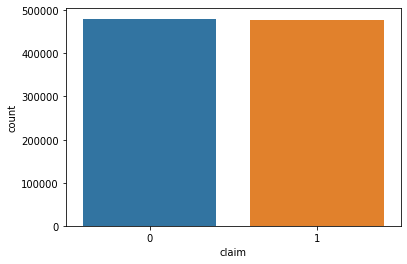

In [ ]:
sns.countplot(train_df['claim'])

We have null Values in our dataset, therefore a inputer method with median was chosen

In [ ]:
imp =  SimpleImputer(missing_values=np.nan, strategy='median')

In [ ]:
X = train_df.drop(['id','claim'],axis = 1)
y = train_df.claim

In [ ]:
X = imp.fit_transform(X)
X_test = imp.fit_transform(test_df.drop('id',axis = 1))

In [ ]:
rob = RobustScaler()
X = rob.fit_transform(X)
X_test = rob.fit_transform(X_test)

## Machine Learning

### LightGMB

In [ ]:
tunning = False # True, if you want to hypertunning

In [ ]:
if tunning :
 
  def objective(trial):
      train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25)
      dtrain = lgb.Dataset(train_x, label=train_y)
  
      param = {
          'objective': 'binary',
          'metric': 'auc',
          'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
          'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
          'num_leaves': trial.suggest_int('num_leaves', 2, 256),
          'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
          'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
          'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
          'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
      }
  
      gbm = lgb.train(param, dtrain)
      preds = gbm.predict(test_x)
      pred_labels = np.rint(preds)
      accuracy = accuracy_score(test_y, pred_labels)
      return accuracy
  
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=50)
  
  print('Number of finished trials:', len(study.trials))
  print('Best trial:', study.best_trial.params)
  param = study.best_trial.params
  param
  param['objective'] = 'binary'
else :
  param = {'bagging_fraction': 0.9556136342570964,
 'bagging_freq': 7,
 'feature_fraction': 0.9093664719465578,
 'lambda_l1': 0.0009731112192839761,
 'lambda_l2': 0.05022674259693464,
 'metric': 'auc',
 'min_child_samples': 53,
 'num_leaves': 136,
 'objective': 'binary'}


In [ ]:
features = test_df.drop('id',axis = 1).columns.to_list()

In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state=None)
oof = np.zeros(len(train_df))
predictions_lgbm = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    fold_ += 1
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X[trn_idx], label=y[trn_idx])
    val_data = lgb.Dataset(X[val_idx], label=y[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 300)
    oof[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgbm += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits


Fold 1
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[372]	training's auc: 0.860246	valid_1's auc: 0.788205
Fold 2
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[433]	training's auc: 0.86888	valid_1's auc: 0.79137
Fold 3
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[312]	training's auc: 0.851007	valid_1's auc: 0.788776
Fold 4
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[502]	training's auc: 0.878224	valid_1's auc: 0.790514
Fold 5
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[345]	training's auc: 0.855895	valid_1's auc: 0.789938
Fold 6
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[399]	training's auc: 0.864155	valid_1's auc: 0.789552
Fold 7
Training until validation scores do

In [ ]:
preds_ac = [int(i > .5) for i in oof]

In [ ]:
print("\n\n")
print('-'*1000)
print("ROC CV score: {:<8.5f}".format(roc_auc_score(train_df['claim'].values, oof)))
print("Accuracy CV score: {:<8.5f}".format(accuracy_score(train_df['claim'].values, preds_ac)))
print('-'*1000)




-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### XGBoost

In [ ]:
tunning = False

if tunning:

  def objective(trial):
      #(data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
      train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
      dtrain = xgb.DMatrix(train_x, label=train_y)
      dvalid = xgb.DMatrix(valid_x, label=valid_y)

      param = {
          "verbosity": 0,
          "objective": "binary:logistic",
          "eval_metric": 'auc',
          # use exact for small dataset.
          "tree_method": "exact",
          # defines booster, gblinear for linear functions.
          "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
          # L2 regularization weight.
          "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
          # L1 regularization weight.
          "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
          # sampling ratio for training data.
          "subsample": trial.suggest_float("subsample", 0.2, 1.0),
          # sampling according to each tree.
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
      }

      if param["booster"] in ["gbtree", "dart"]:
          # maximum depth of the tree, signifies complexity of the tree.
          param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
          # minimum child weight, larger the term more conservative the tree.
          param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
          param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
          # defines how selective algorithm is.
          param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
          param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

      if param["booster"] == "dart":
          param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
          param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
          param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
          param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

      bst = xgb.train(param, dtrain)
      preds = bst.predict(dvalid)
      pred_labels = np.rint(preds)
      accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
      return accuracy


  if __name__ == "__main__":
      study = optuna.create_study(direction="maximize")
      study.optimize(objective, n_trials=100, timeout=600)

      print("Number of finished trials: ", len(study.trials))
      print("Best trial:")
      trial = study.best_trial

      print("  Value: {}".format(trial.value))
      print("  Params: ")
      for key, value in trial.params.items():
          print("    {}: {}".format(key, value))

      param = study.best_trial.params
      param['eval_metric'] = 'auc'
else:
  param = {'alpha': 0.9286263881717246,
  'eval_metric' : 'auc',
 'booster': 'gbtree',
 'colsample_bytree': 0.7317911276911447,
 'eta': 0.4994795364431274,
 'gamma': 1.7554366442993805e-08,
 'grow_policy': 'lossguide',
 'lambda': 1.0681330380503332e-08,
 'max_depth': 9,
 'min_child_weight': 5,
 'subsample': 0.9961101392862352}

[I 2021-09-05 13:36:41,820] A new study created in memory with name: no-name-51c91e8d-f96d-4273-8888-dbf8c2f6c6fe
[I 2021-09-05 13:37:28,440] Trial 0 finished with value: 0.5328712209787874 and parameters: {'booster': 'dart', 'lambda': 3.9147528429830035e-08, 'alpha': 3.8770723344403604e-05, 'subsample': 0.8285429311623191, 'colsample_bytree': 0.7408497468110313, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.002113324322335961, 'gamma': 5.509691201816342e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.23481257951118759, 'skip_drop': 9.857934748711291e-06}. Best is trial 0 with value: 0.5328712209787874.
[I 2021-09-05 13:37:45,672] Trial 1 finished with value: 0.5382286621012193 and parameters: {'booster': 'dart', 'lambda': 0.0001689990698384423, 'alpha': 2.6037387377976437e-08, 'subsample': 0.9671927789870047, 'colsample_bytree': 0.37940518266289774, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.0015558353770261974, 'gamma': 0.005

Number of finished trials:  18
Best trial:
  Value: 0.6242525471855688
  Params: 
    booster: gbtree
    lambda: 0.9246557379114444
    alpha: 0.0677132520300839
    subsample: 0.814072756976796
    colsample_bytree: 0.5476396729915024
    max_depth: 7
    min_child_weight: 4
    eta: 0.9858626530586154
    gamma: 0.2092629793493278
    grow_policy: lossguide


In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state=None)
oof = np.zeros(len(train_df))
predictions_xgb = np.zeros(len(test_df))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    fold_ += 1
    print("Fold {}".format(fold_))
    trn_data = xgb.DMatrix(X[trn_idx], label=y[trn_idx])
    val_data = xgb.DMatrix(X[val_idx], label=y[val_idx])

    num_round = 200
    clf = xgb.train(param,trn_data, num_round,evals=[(val_data,'val')],verbose_eval= 25,early_stopping_rounds= 10)
    x_val = xgb.DMatrix(X[val_idx])
    oof[val_idx] = clf.predict(x_val)
    
    test = xgb.DMatrix(X_test)
    predictions_xgb += clf.predict(test) / folds.n_splits


Fold 1
[0]	val-auc:0.534664
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.713399
[50]	val-auc:0.725747
Stopping. Best iteration:
[40]	val-auc:0.727797

Fold 2
[0]	val-auc:0.53438
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.719695
Stopping. Best iteration:
[35]	val-auc:0.727052

Fold 3
[0]	val-auc:0.538202
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.718837
[50]	val-auc:0.728379
Stopping. Best iteration:
[43]	val-auc:0.7291

Fold 4
[0]	val-auc:0.531355
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.717264
[50]	val-auc:0.726361
Stopping. Best iteration:
[47]	val-auc:0.72722

Fold 5
[0]	val-auc:0.537237
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.717196
[50]	val-auc:0.726292
Stopping. Best iteration:
[44]	val-auc:0.72792

Fold 6
[0]	val-auc:0.531013
Will train until val-auc hasn't improved in 10 rounds.
[25]	val-auc:0.717763
Stopping. Best iteration:
[34]	val-auc:0.7

In [ ]:
preds_ac = [int(i > .5) for i in oof]
print("\n\n")
print('-'*1000)
print("ROC CV score: {:<8.5f}".format(roc_auc_score(train_df['claim'].values, oof)))
print("Accuracy CV score: {:<8.5f}".format(accuracy_score(train_df['claim'].values, preds_ac)))
print('-'*1000)




-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Stacking Classificator

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
lgbm_params = {'bagging_fraction': 0.9556136342570964,
 'bagging_freq': 7,
 'feature_fraction': 0.9093664719465578,
 'lambda_l1': 0.0009731112192839761,
 'lambda_l2': 0.05022674259693464,
 'metric': 'auc',
 'min_child_samples': 53,
 'num_leaves': 136,
 'objective': 'binary' }

xgb_params = {'alpha': 0.9286263881717246,
  'eval_metric' : 'auc',
 'colsample_bytree': 0.7317911276911447,
 'eta': 0.4994795364431274,
 'gamma': 1.7554366442993805e-08,
 'grow_policy': 'lossguide',
 'lambda': 1.0681330380503332e-08,
 'max_depth': 9,
 'min_child_weight': 5,
 'subsample': 0.9961101392862352}

In [ ]:
clf1 = RandomForestClassifier()
clf2 = lgb.LGBMClassifier(**lgbm_params)
clf3 = xgb.XGBRFClassifier(**xgb_params)
lr = LogisticRegression()

In [ ]:
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,cv = 5,
                            use_probas = True,use_features_in_secondary = True)

In [ ]:
sclf.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_le

## Predctions

In [ ]:
predictions_stack = sclf.predict_proba(X_test)

In [ ]:
total_pred = 0.5*np.expm1(predictions_lgbm) + 0.5*np.expm1(predictions_xgb)

In [ ]:
sub_df = pd.DataFrame({"id":test_df["id"].values})
sub_df["claim"] = predictions_stack[:,1]
sub_df.to_csv("submission.csv", index=False)

In [ ]:
! kaggle competitions submit -c tabular-playground-series-sep-2021 -f submission.csv -m "LightGMB XGBoost Stack"

100% 12.8M/12.8M [00:00<00:00, 23.6MB/s]
400 - Bad Request
